In [118]:
import json
from boto import kinesis

import cv2
import numpy as np
import socket
import sys
import pickle as cPickle
import struct
from multiprocessing import Pool
import pytz ## for timezone calculations
import datetime

import time

In [119]:
cap = cv2.VideoCapture(0)
grabbed, frame = cap.read()
frame = cv2.resize(frame, (640, 480))

cap.release()
cv2.destroyAllWindows()
frame

array([[[135, 140, 140],
        [135, 140, 140],
        [135, 140, 140],
        ...,
        [122, 119, 122],
        [122, 120, 120],
        [123, 121, 121]],

       [[135, 140, 140],
        [135, 140, 140],
        [135, 140, 140],
        ...,
        [121, 121, 121],
        [121, 122, 119],
        [121, 122, 119]],

       [[135, 140, 140],
        [134, 139, 139],
        [135, 140, 140],
        ...,
        [121, 121, 121],
        [122, 123, 120],
        [120, 120, 118]],

       ...,

       [[126, 136, 140],
        [127, 137, 141],
        [127, 137, 141],
        ...,
        [ 44,  39,  40],
        [ 42,  39,  40],
        [ 42,  39,  40]],

       [[127, 137, 141],
        [127, 137, 141],
        [127, 137, 141],
        ...,
        [ 44,  39,  41],
        [ 44,  39,  40],
        [ 45,  40,  41]],

       [[127, 137, 141],
        [127, 137, 141],
        [127, 137, 141],
        ...,
        [ 46,  41,  44],
        [ 46,  41,  44],
        [ 46,  41,  44]]

In [120]:
frame.shape

(480, 640, 3)

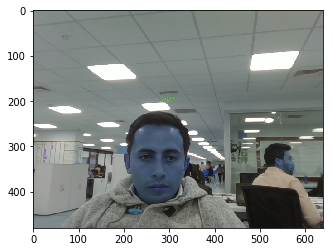

In [121]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

imgplot = plt.imshow(frame)

In [122]:
retval, buff = cv2.imencode(".jpg", frame)
buff

array([[255],
       [216],
       [255],
       ...,
       [ 76],
       [255],
       [217]], dtype=uint8)

In [123]:
%%time
img_bytes = bytearray(buff)
sys.getsizeof(img_bytes)
img_bytes

Wall time: 0 ns


In [124]:
%%time
utc_dt = pytz.utc.localize(datetime.datetime.now())
now_ts_utc = (utc_dt - datetime.datetime(1970, 1, 1, tzinfo=pytz.utc)).total_seconds()

frame_package = {
            'ApproximateCaptureTime' : now_ts_utc,
            'FrameCount' : 0,
            'ImageBytes' : img_bytes
        }

now_ts_utc

Wall time: 0 ns


In [125]:
%%time
serializado = cPickle.dumps(frame_package)
serializado

Wall time: 0 ns


In [127]:
print(sys.getsizeof(buff)/1000)
print(sys.getsizeof(frame)/1000)

78.548
921.728


In [10]:
print(sys.getsizeof(frame)/1e6)
print(sys.getsizeof(buff)/1e6)
print(sys.getsizeof(img_bytes)/1e6)
print(sys.getsizeof(serializado)/1e6)

0.921728
0.077855
0.0778
0.077893


In [11]:
%%time
## UnPickle ......
unFrame = cPickle.loads(serializado)['ImageBytes']

Wall time: 0 ns


In [12]:
unFrame = np.asarray(unFrame, dtype=np.uint8)
unFrame = unFrame.reshape((unFrame.shape[0], 1))

In [13]:
print(buff.shape)
print(unFrame.shape)

(77743, 1)
(77743, 1)


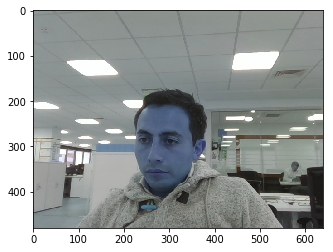

In [20]:
#unFrame.astype('uint8')
unFrame = cv2.imdecode(unFrame, cv2.COLOR_BGR2RGB)

# Plot
plt.imshow(unFrame)

In [21]:
print(unFrame.shape)
print(sys.getsizeof(unFrame)/1e6)

(480, 640, 3)
0.921728


In [ ]:
frame_count = 0
target = open("img_{}.jpg".format(frame_count), 'wb')
target.write(unFrame)
target.close()

## Streamer

In [56]:
import boto3
import time
import cv2
import numpy as np
import pickle as cPickle

aws_region = "us-west-2"
stream_name = "TestStream"

kinesis = boto3.client('kinesis', region_name=aws_region)
#kinesis = kinesis.connect_to_region("us-west-2")
stream_name = "TestStream"

In [98]:
response = kinesis.describe_stream(StreamName = stream_name)
response

{'StreamDescription': {'StreamName': 'TestStream',
  'StreamARN': 'arn:aws:kinesis:us-west-2:733097393942:stream/TestStream',
  'StreamStatus': 'ACTIVE',
  'Shards': [{'ShardId': 'shardId-000000000000',
    'HashKeyRange': {'StartingHashKey': '0',
     'EndingHashKey': '340282366920938463463374607431768211455'},
    'SequenceNumberRange': {'StartingSequenceNumber': '49596454524758706160307275079697372537066901325505101826'}}],
  'HasMoreShards': False,
  'RetentionPeriodHours': 24,
  'StreamCreationTimestamp': datetime.datetime(2019, 6, 7, 9, 27, 34, tzinfo=tzlocal()),
  'EnhancedMonitoring': [{'ShardLevelMetrics': []}],
  'EncryptionType': 'NONE'},
 'ResponseMetadata': {'RequestId': 'f2a93a10-3a47-5599-a7d1-87812cf5c9fb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f2a93a10-3a47-5599-a7d1-87812cf5c9fb',
   'x-amz-id-2': 's1A1KSzLsVSVtLvfWafcWyP+xD72NNIskZPSeuHtbKuafUHGRhhaBko2PiiqaF4qeHI2nszk1MqOJWW8nNoVhd4TP4h8qfpKq0BqprFzmNg=',
   'date': 'Mon, 10 Jun 2019 20:19:

In [99]:
shard_id = response['StreamDescription']['Shards'][0]['ShardId']
shard_id

'shardId-000000000000'

In [100]:
#shard_it = kinesis.get_shard_iterator(stream_name, shard_id, "LATEST")["ShardIterator"]
shard_it = kinesis.get_shard_iterator(StreamName = stream_name,
                                      ShardId = shard_id,
                                      ShardIteratorType='LATEST')['ShardIterator']
shard_it

'AAAAAAAAAAHHDfD4ZMymDu8Z8oSJq1DoCVnRuWBb0HzhcsUxGby/8hfkHBX+c/stGp1SXAp/KP0H5tIseMamx5nkbIyeBW2Fg1RB+3Tr78ZiKI5WGDQSfIcPhBAKUJFqqcgyzkAZn9PmuHXR2WJrGi1+zC5tm7/d439p60b772XCjM5QSiudgkvDZbRmrXARYJ5/ZeHosOiEioi9EM2KGi/2jxmd7POb'

In [101]:
%%time
#out = kinesis.get_records(shard_it, limit=1)
out = kinesis.get_records(ShardIterator = shard_it,
                          Limit=1)
out

Wall time: 1.41 s


In [102]:
len(out)

4

In [103]:
frame = cPickle.loads(out['Records'][0]['Data'])['ImageBytes']
frame = np.asarray(frame, dtype=np.uint8)
frame = frame.reshape((frame.shape[0], 1))
newframe = cv2.imdecode(frame, cv2.COLOR_BGR2RGB)


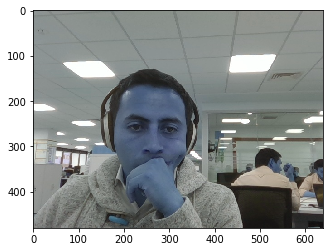

In [104]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

# Plot
plt.imshow(newframe)

In [111]:
capture_rate = 30 
print('...sending 1/%5d frames to AWS' % capture_rate)

...sending 1/   30 frames to AWS


In [112]:
print("Art: 1/%5d, Priece per unit: %8.2f" % (453, 59.058))

Art: 1/  453, Priece per unit:    59.06


In [115]:
print('...sending 1/{a:5d} frames to AWS'.format(a=capture_rate))

...sending 1/   30 frames to AWS
